# Training Data

> I'll use this notebook to build a dataset of training data by manipulating existing json data

Steps:
1. Build ability to display masks on image from image + json file
2. Build ability to create json files from images using existing model
3. Start by doing it manually
4. Build a program that can let you merge two masks together when you specify their index
5. Build a program where you can input the lines to be merged for an image and it merges all of them. That should be enough to build 100 or so training jsons in an hour. Not perfect but will work.

## Setup Environment
> Assuming all dependencies from main notebook have been installed

## Import Dependencies

In [1]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
from typing import Any, Dict, Optional

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Set Constants and Global Variables

In [2]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cuda', torch.float32)

In [3]:
dataset_path = Path(f'Datasets/mrcnn-text-segmentation/Datasets/all_datasets/')

In [4]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


## Import and Pre-Process Dataset

### Helper Functions

In [5]:
def get_file_paths(path_to_dataset):
    # Get a list of image files in the dataset
    img_file_paths = get_img_files(path_to_dataset)
    
    # Get a list of JSON files in the dataset
    annotation_file_paths = list(path_to_dataset.glob('*.json'))

    return img_file_paths, annotation_file_paths

In [6]:
def get_img_dict(image_paths):
    # Create a dictionary that maps file names to file paths
    img_dict = {file.stem : file for file in image_paths}
    return img_dict

In [7]:
def create_annotation_df(annotation_paths, image_dict):
    # Create a generator that yields Pandas DataFrames containing the data from each JSON file
    cls_dataframes = (pd.read_json(f, orient='index').transpose() for f in tqdm(annotation_paths))
    
    # Concatenate the DataFrames into a single DataFrame
    annotation_df = pd.concat(cls_dataframes, ignore_index=False)
    
    # Assign the image file name as the index for each row
    annotation_df['index'] = annotation_df.apply(lambda row: row['imagePath'].split('.')[0], axis=1)
    annotation_df = annotation_df.set_index('index')
    
    # Keep only the rows that correspond to the filenames in the 'img_dict' dictionary
    annotation_df = annotation_df.loc[list(image_dict.keys())]

    return annotation_df

In [8]:
def create_shapes_df(annotation_dataframe):
    # Explode the 'shapes' column in the annotation_df dataframe
    # Convert the resulting series to a dataframe and rename the 'shapes' column to 'shapes'
    # Apply the pandas Series function to the 'shapes' column of the dataframe
    shapes_df = annotation_dataframe['shapes'].explode().to_frame().shapes.apply(pd.Series)
    
    # Get a list of unique labels in the 'annotation_df' DataFrame
    class_names = shapes_df['label'].unique().tolist()
    
    # Get the number of samples for each object class
    class_counts = shapes_df['label'].value_counts()
    return shapes_df, class_names, class_counts

In [9]:
def add_background(class_names):
    # Prepend a `background` class to the list of class names
    class_names = ['background']+class_names
    return class_names

In [10]:
def get_colors(class_names):
    # Generate a list of colors with a length equal to the number of labels
    colors = distinctipy.get_colors(len(class_names))
    
    # Make a copy of the color map in integer format
    int_colors = [tuple(int(c*255) for c in color) for color in colors]

    return colors, int_colors

### Primary Function & Function Call

In [11]:
def prepare_dataset(path_to_dataset):
    img_paths, annotation_paths = get_file_paths(path_to_dataset)
    image_dict = get_img_dict(img_paths)
    annotation_df = create_annotation_df(annotation_paths, image_dict)
    shapes_df, class_names, class_counts = create_shapes_df(annotation_df)
    class_names = add_background(class_names)
    colors, int_colors = get_colors(class_names)
    return img_paths, annotation_paths, image_dict, annotation_df, shapes_df, class_counts, class_names, colors, int_colors

In [12]:
img_paths, annotation_paths, img_dict, annotation_df, shapes_df, class_counts, class_names, colors, int_colors = prepare_dataset(dataset_path)

  0%|          | 0/124 [00:00<?, ?it/s]

## Process and Display an Image

In [13]:
def get_image(image_dict, idx):
    # Get the file ID of the first image file
    file_id = list(image_dict.keys())[idx]

    # Open the associated image file as a RGB image
    sample_img = Image.open(img_dict[file_id]).convert('RGB')

    return file_id, sample_img

In [14]:
def get_labels_masks_bboxes(annotation_df, file_id, sample_img):
    # Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
    annotation_df.loc[file_id].to_frame()
    
    # Extract the labels for the sample
    labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
    
    # Extract the polygon points for segmentation mask
    shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]

    # Format polygon points for PIL
    xy_coords = [[tuple(p) for p in points] for points in shape_points]
    
    # Generate mask images from polygons
    mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
    
    # Convert mask images to tensors
    masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
    
    # Generate bounding box annotations from segmentation masks
    bboxes = torchvision.ops.masks_to_boxes(masks)

    return labels, masks, bboxes
    

In [15]:
def create_polygon_mask(image_size, vertices):
    """
    Create a grayscale image with a white polygonal area on a black background.

    Parameters:
    - image_size (tuple): A tuple representing the dimensions (width, height) of the image.
    - vertices (list): A list of tuples, each containing the x, y coordinates of a vertex
                        of the polygon. Vertices should be in clockwise or counter-clockwise order.

    Returns:
    - PIL.Image.Image: A PIL Image object containing the polygonal mask.
    """

    # Create a new black image with the given dimensions
    mask_img = Image.new('L', image_size, 0)
    
    # Draw the polygon on the image. The area inside the polygon will be white (255).
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))

    # Return the image with the drawn polygon
    return mask_img

In [16]:
def annotate_with_masks(tensor_img, masks, integer_colors, class_names, labels):
    # Annotate the sample image with segmentation masks
    annotated_tensor = draw_segmentation_masks(
        image=tensor_img, 
        masks=masks,
        alpha=0.3,
        colors=[integer_colors[i] for i in [class_names.index(label) for label in labels]]
    )
    return annotated_tensor
    

In [17]:
def annotate_with_bboxes(tensor_img, bboxes, labels, int_colors, class_names):
    draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)
    
    # Annotate the sample image with labels and bounding boxes
    tensor_img = draw_bboxes(
        image=tensor_img,
        boxes=bboxes, 
        labels=labels, 
        colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
    )
    return tensor_img

In [18]:
def add_annotations(sample_image, masks, bboxes, integer_colors, class_names, labels, do_masks=True, do_bboxes=True):
    tensor = transforms.PILToTensor()(sample_image)
    if do_masks:
        tensor = annotate_with_masks(tensor, masks, integer_colors, class_names, labels)
    if do_bboxes:
        annotated_tensor = annotate_with_bboxes(tensor, bboxes, labels, int_colors, class_names)
    return annotated_tensor

In [19]:
def annotate_image(image_dict, idx, annotation_df, integer_colors, class_names, do_masks=True, do_bboxes=True):
    file_id, sample_image = get_image(image_dict, idx)
    labels, masks, bboxes = get_labels_masks_bboxes(annotation_df, file_id, sample_image)
    annotated_tensor = add_annotations(sample_image, masks, bboxes, integer_colors, class_names, labels, do_masks, do_bboxes)
    return tensor_to_pil(annotated_tensor)

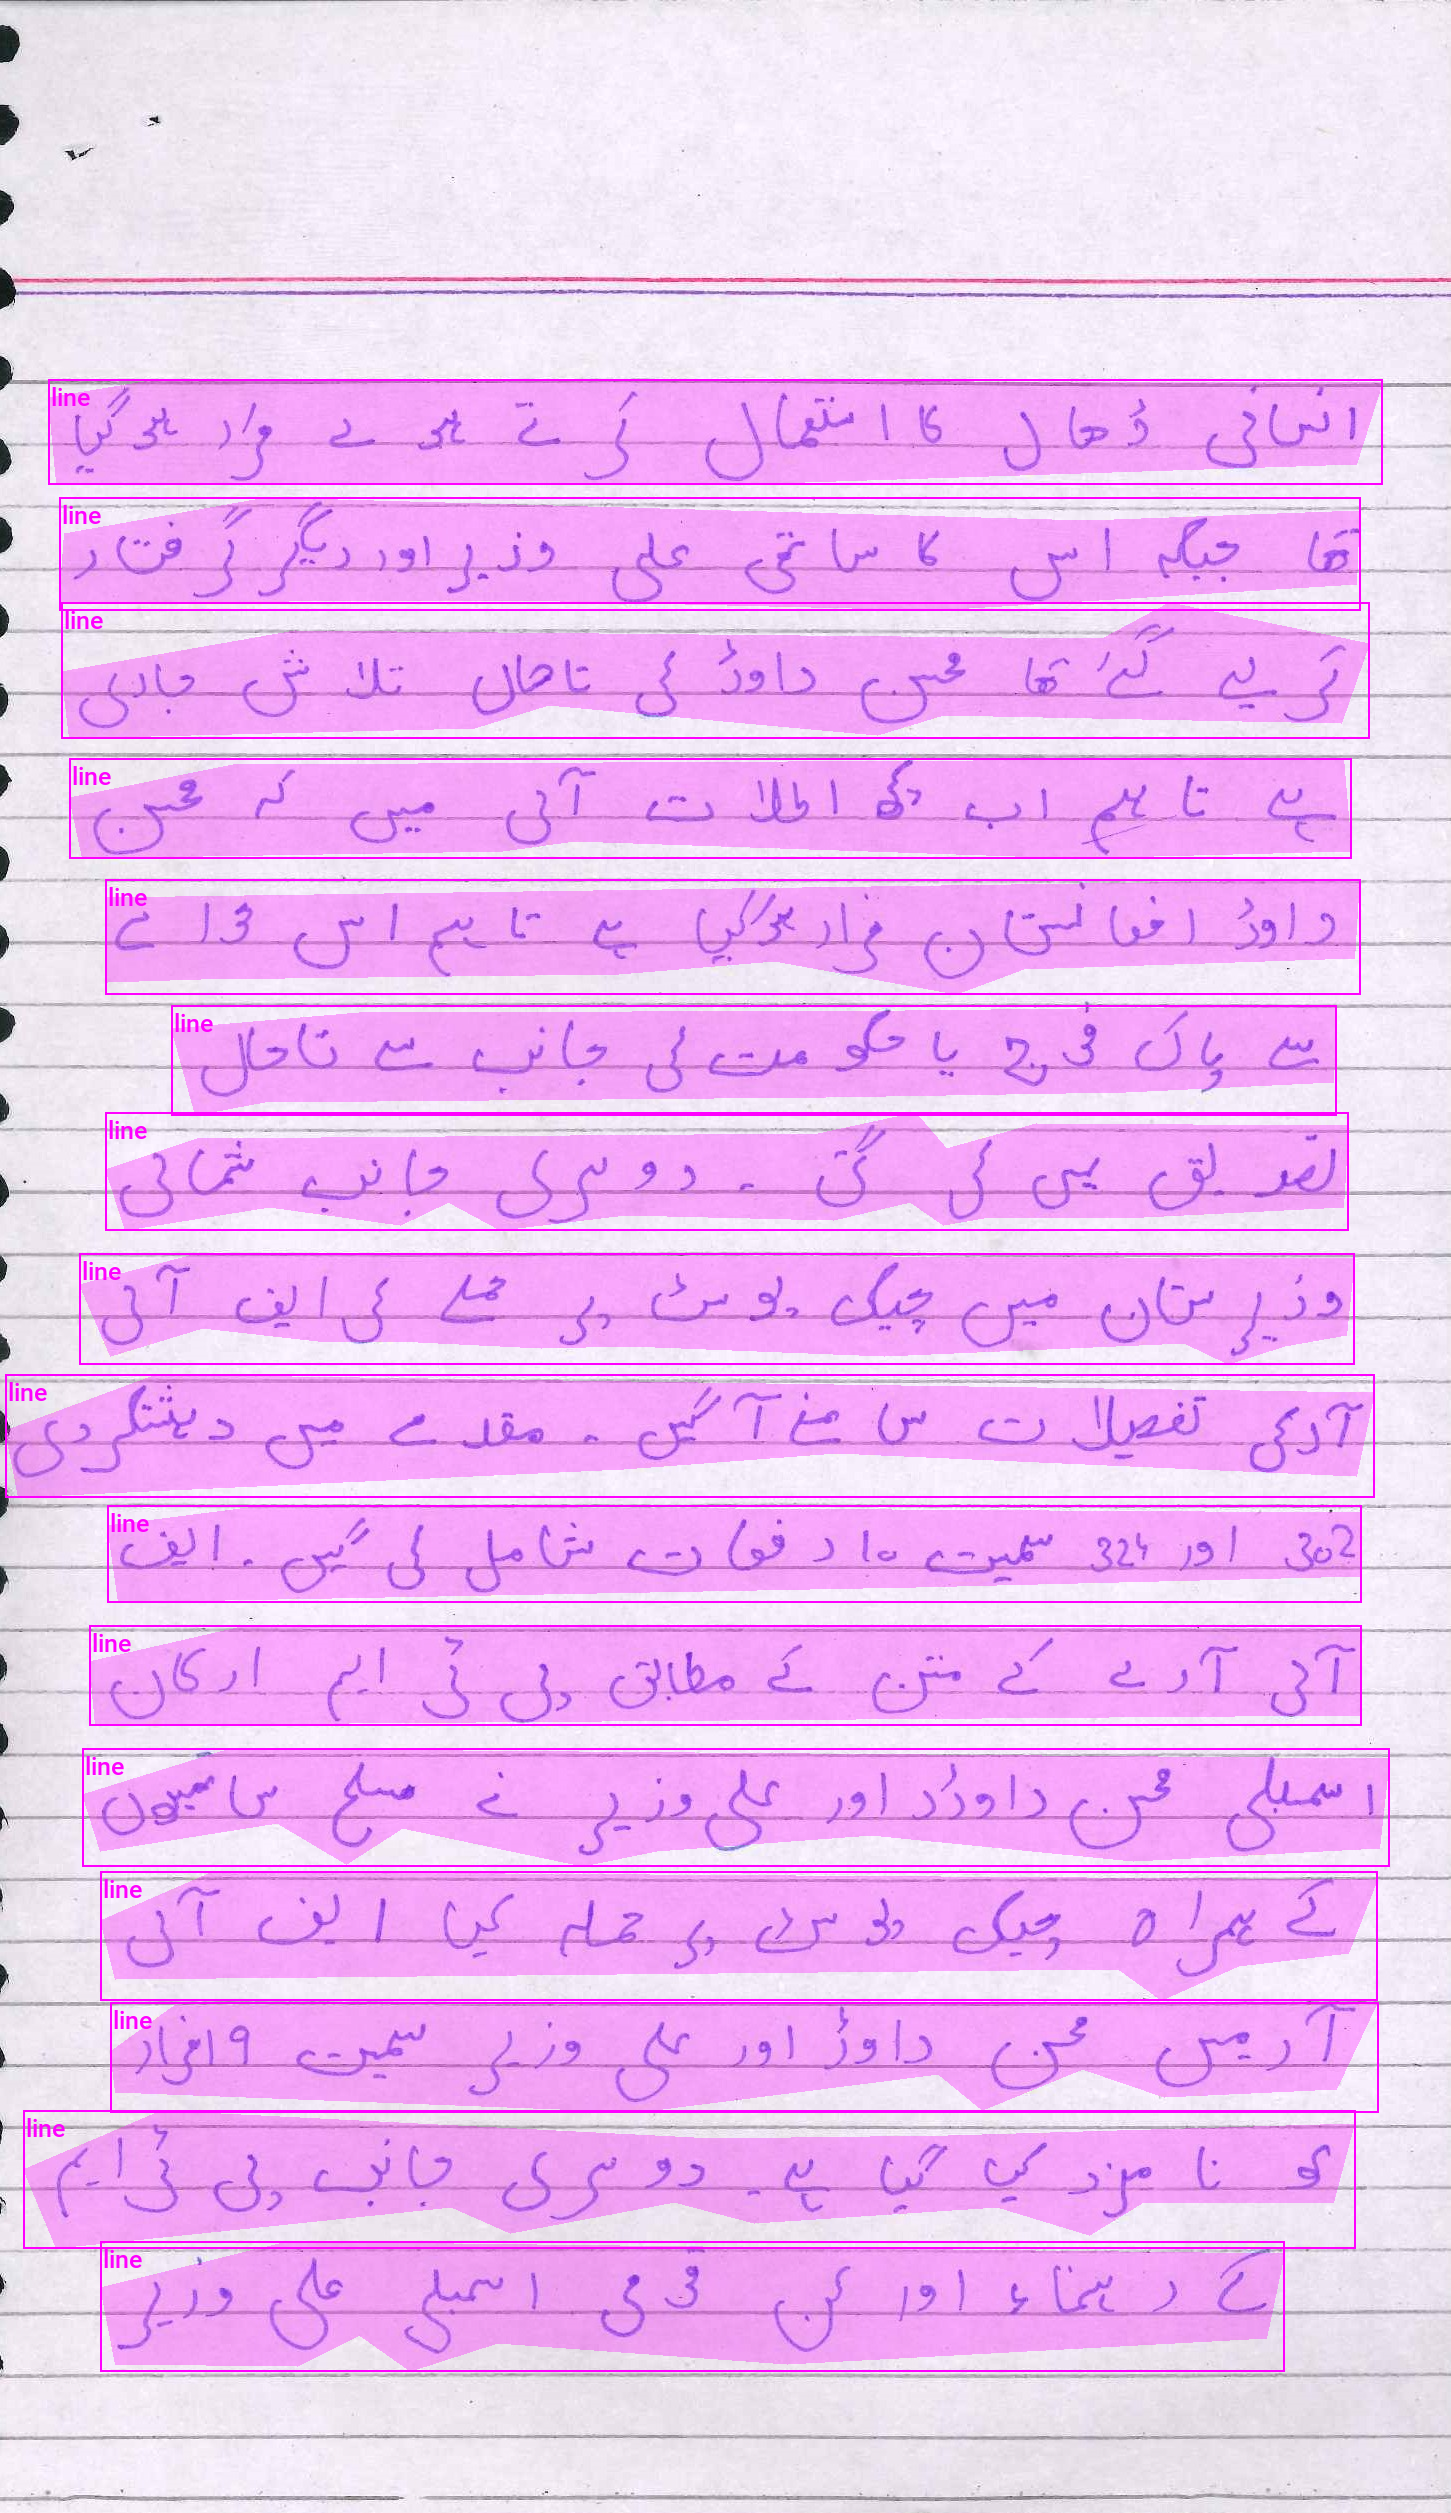

In [20]:
annotated_img = annotate_image(img_dict, 56, annotation_df, int_colors, class_names, do_masks=True, do_bboxes=True)
annotated_img